# Import Library

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mping
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

# Lane Tracking Pipeline

In [2]:
class LaneTracker:

    def __init__(self, mtx, dist):
        # matrix from calibrating camera
        self.mtx = mtx
        # distortion coefficients from calibrating camera
        self.dist = dist
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the left line
        self.recent_left_xfitted = []
        # x values of the last n fits of the right line
        self.recent_right_xfitted = []
        # polynomial coefficients for left averaged over the last n iterations
        self.best_left_fit = None
        # polynomial coefficients for right averaged over the last n iterations
        self.best_right_fit = None
        # polynomial coefficients for the most recent left fit
        self.current_left_fit = [np.array([False])]
        # polynomial coefficients for the most recent right fit
        self.current_right_fit = [np.array([False])]
        # radius of curvature of the line in some units
        self.radius_of_curvature = None
        # distance in meters of vehicle center from the line
        self.center_offset = None
        
    def make_binary(self, image, ksize = 11, mask_half=False):
    
        hls = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2HLS)
        gray = (0.5*image[:,:,0] + 0.4*image[:,:,1] + 0.1*image[:,:,2]).astype(np.uint8)
        s = hls[:,:,2]

        _, gray_binary = cv2.threshold(gray.astype('uint8'), 150, 255, cv2.THRESH_BINARY)

        total_px = image.shape[0]*image.shape[1]
        laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
        mask_three = (laplacian < 0.15*np.min(laplacian)).astype(np.uint8)
        if cv2.countNonZero(mask_three)/total_px < 0.01:
            laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
            mask_three = (laplacian < 0.075*np.min(laplacian)).astype(np.uint8)

        _, s_binary = cv2.threshold(s.astype('uint8'), 150, 255, cv2.THRESH_BINARY)
        mask_two = s_binary

        combined_binary = np.clip(cv2.bitwise_and(gray_binary, 
                            cv2.bitwise_or(mask_three, mask_two)), 0, 1).astype('uint8')

        # Mask out top half of image to reduce distractions
        # Only used when unwarped image is passed in
        if mask_half:
            combined_binary[:ceil(image.shape[0]//2)] = 0

        return combined_binary

    def perspective_transform_matrix(self, img, img_size):
    #     print(img_size)
        src = np.float32(\
        [[(img_size[0] / 2) - 75, img_size[1] / 2 + 110],\
         [((img_size[0] / 6) - 10), img_size[1]],\
         [(img_size[0] * 5 / 6) + 60, img_size[1]],\
         [(img_size[0] / 2 + 75), img_size[1] / 2 + 110]]) 

        dst = np.float32(\
        [[(img_size[0] / 4), 0],\
         [(img_size[0] / 4), img_size[1]],\
         [(img_size[0] * 3 / 4), img_size[1]],\
         [(img_size[0] * 3 / 4), 0]])

        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)

        return M, Minv
    
    def warpImage(self, img, M, img_size):
        return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    def apply_lines(self, img):
        # Undistort the image
        img = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        img_size = img.shape[:2][::-1]
        
        # Find binary image
        combined_binary = self.make_binary(img)

        # Find perspective transform and warped image
        M, Minv = self.perspective_transform_matrix(img, img_size)
        warped_binary = self.warpImage(combined_binary, M, img_size)
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warped_binary.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_idx = []
        right_lane_idx = []

        # Set the width of the windows +/- margin
        margin = 100
        # Choose the number of sliding windows
        nwindows = 9
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        bias = 0.2
        
        # Only search the entire image if lines have not been previously detected
        if not self.detected:
            # Take a histogram of the bottom half of the image
            histogram = np.sum(warped_binary[warped_binary.shape[0]//2:,:], axis=0)
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]/2)
            leftstart = int((1-bias)*midpoint)
            rightstart = int((1+bias)*midpoint)

            leftx_base = np.argmax(histogram[:leftstart])
            rightx_base = np.argmax(histogram[rightstart:]) + rightstart

            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base

            # Set height of windows
            window_height = np.int(warped_binary.shape[0]/nwindows)

            
            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = warped_binary.shape[0] - (window+1)*window_height
                win_y_high = warped_binary.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                # Identify the nonzero pixels in x and y within the window
                good_left_idx = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_idx = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_idx.append(good_left_idx)
                right_lane_idx.append(good_right_idx)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_idx) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_idx]))
                if len(good_right_idx) > minpix:
                    rightx_current = np.int(np.mean(nonzerox[good_right_idx]))

            # Concatenate the arrays of indices
            left_lane_idx = np.concatenate(left_lane_idx)
            right_lane_idx = np.concatenate(right_lane_idx)
            self.detected = True

        else:
            left_lane_idx = ((nonzerox > (self.best_left_fit[0]*(nonzeroy**2) + self.best_left_fit[1]*nonzeroy \
                            + self.best_left_fit[2] - margin)) & (nonzerox < (self.best_left_fit[0]*(nonzeroy**2) \
                            + self.best_left_fit[1]*nonzeroy + self.best_left_fit[2] + margin)))
            right_lane_idx = ((nonzerox > (self.best_right_fit[0]*(nonzeroy**2) + self.best_right_fit[1]*nonzeroy \
                            + self.best_right_fit[2] - margin)) & (nonzerox < (self.best_right_fit[0]*(nonzeroy**2) \
                            + self.best_right_fit[1]*nonzeroy + self.best_right_fit[2] + margin)))

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_idx]
        lefty = nonzeroy[left_lane_idx]
        rightx = nonzerox[right_lane_idx]
        righty = nonzeroy[right_lane_idx]

        # polynomial coefficients for the most recent fit
        self.current_left_fit = np.polyfit(lefty, leftx, 2)
        self.current_right_fit = np.polyfit(righty, rightx, 2)

        # x values of the last n fits of the left line
        self.recent_left_xfitted.append(self.current_left_fit)
        # x values of the last n fits of the right line
        self.recent_right_xfitted.append(self.current_right_fit)

        self.best_left_fit = np.mean(self.recent_left_xfitted[-min(15,len(self.recent_left_xfitted)):], axis=0)
        self.best_right_fit = np.mean(self.recent_right_xfitted[-min(15,len(self.recent_right_xfitted)):], axis=0)

        # Generate x and y values for plotting
        ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0])
        left_fitx = self.best_left_fit[0]*ploty**2 + self.best_left_fit[1]*ploty + self.best_left_fit[2]
        right_fitx = self.best_right_fit[0]*ploty**2 + self.best_right_fit[1]*ploty + self.best_right_fit[2]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Create an image to draw the lines
        warp_zero = np.zeros_like(warped_binary[:-20]).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))

        # Warp the blank back to original image space using inverse perspective matrix
        unwarped = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))

        # Combine the result with the original undistorted image
        result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)

        # Compute the raduis of curvature of lane
        # Measure radius of curvature at y-value closest to car
        y_eval = np.max(ploty)

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720
        xm_per_pix = 3.7/700

        # Fit polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
        # Calculate radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        self.radius_of_curvature = (left_curverad + right_curverad)/2

        # Calculate offset of the car between the lane
        camera_center = (left_fitx[-1] + right_fitx[-1])/2
        self.center_offset = (camera_center - unwarped.shape[1]/2)*xm_per_pix
        side_pos = 'left'
        if self.center_offset <= 0:
            side_pos = 'right'

        # draw the text showing curvature, offset, and speed
        cv2.putText(result, 'Radius of curvature: ' + str(round(self.radius_of_curvature, 3))+' (m)',(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
#         cv2.putText(result,'Vehicle is '+str(abs(round(self.center_offset,3)))+'m '+side_pos+' of center',(50,100), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(self.center_offset), side_pos),(50,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
        return result


In [3]:
# Load test images.
testImages = list(map(lambda imageFileName: cv2.imread(imageFileName), 
                      glob.glob('./test_images/*.jpg')))

# Let's test our pipeline on a sample

In [4]:
def test_image(input_image):
    # Read in the saved matrix and distortion coefficients
    # Loading camera calibration
    mtx, dist, rvecs, tvecs = pickle.load( open('./cameraCalibration.pickle', 'rb' ) )

    # Create LaneTracker object with matrix and distortion coefficients
    lane_tracker = LaneTracker(mtx, dist)
    
    plt.imshow(lane_tracker.apply_lines(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)))

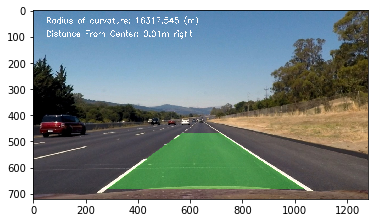

In [5]:
test_image(testImages[1])

# Run the pipeline on video

In [6]:
def process_video(input_video):
    # Read in the saved matrix and distortion coefficients
    # Loading camera calibration
    mtx, dist, rvecs, tvecs = pickle.load( open('./cameraCalibration.pickle', 'rb' ) )

    # Create LaneTracker object with matrix and distortion coefficients
    lane_tracker = LaneTracker(mtx, dist)

    # Name of output video after applying lane lines
    output_video = input_video.split('.')[0]+'_output.mp4'

    # Apply lane lines to each frame of input video and save as new video file
    clip1 = VideoFileClip(input_video)
    video_clip = clip1.fl_image(lane_tracker.apply_lines)
    video_clip.write_videofile(output_video, audio=False)

In [35]:
process_video('project_video.mp4')

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:25<00:00,  4.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

